<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoders

Implementation from the paper - https://arxiv.org/abs/1312.6114 by Kingma and Welling

## Installations

In [0]:
%%capture
!pip install tqdm six


!pip install bokeh
!pip install tensorboard
!pip install livelossplot

!pip install tensorboard


## Connect to google drive

In [3]:
from google.colab import drive

drive.mount("/content/drive")


%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/examples/vae/
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Masters-DS/CSCI-B659/project/examples/vae
mnist/  MNIST/  results/


## Imports

In [30]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from livelossplot import PlotLosses


plt.style.use('ggplot')

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Params

In [0]:
params = {
    "batch_size":128,
    "epochs" : 10,
    "log_interval":10
    
}

torch.manual_seed(5)
import os
os.makedirs("./logs")

## Tensor Board


In [0]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()

In [7]:
LOG_DIR = './logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-24 00:37:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.60.111, 52.204.136.9, 52.4.75.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.60.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13584026 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.95M  12.8MB/s    in 1.0s    

2019-03-24 00:37:39 (12.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13584026/13584026]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://a7ca921d.ngrok.io


## VAE

In [8]:
"""
VAE object
"""
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    
    self.fc1 = nn.Linear(784,400)
    self.fc21 = nn.Linear(400,20) # downsample
    self.fc22 = nn.Linear(400,20)
    self.fc3 = nn.Linear(20,400)
    self.fc4 = nn.Linear(400,784) # input image
    
    ## classifier
    self.classifier = nn.Linear(400,10) # out classifier
    
  ## encode x to latent distribution
  def encode(self,x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)
  
  """"
  Reparameterize - trick
  """
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.rand_like(std)
    return eps.mul(std).add_(mu) ## eps*std + mean
  
  """
  Decode back to original image
  """
  def decode(self,z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))
  
  """
  Forward
  """
  def forward(self,x):
    mu, logvar = self.encode(x.view(-1,784))
    z = self.reparameterize(mu, logvar)
    
    return self.decode(z), mu, logvar,self.classifier(F.relu(self.fc3(z)))
  
    
    
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
model
    

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
  (classifier): Linear(in_features=400, out_features=10, bias=True)
)

## Loss function

In [0]:
"""
Joint loss over all the parameters
"""
def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction="sum")
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  return BCE + KLD




class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )


## Train

In [0]:
"""
Train
"""
criterion = nn.CrossEntropyLoss()
logger = TensorBoardLogger("./logs") 

def train(epoch):
  model.train()
  
  
  loss_log = RunningAverage()
  accuracy_log = RunningAverage()

  accuracy = 0.0
  
  for batch_idx, (data, labels ) in enumerate(train_loader):
    data = data.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    batch_size = data.size(0)
    
    recon_batch, mu, logvar,logits = model(data)
    
    
    ## Loss of the classifier
    loss = criterion(logits, labels) ## classifier
    
    ## Loss of VAE
    loss += loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    loss_log.update(loss.item() / len(data))
    # 1. Log scalar values (scalar summary)
    info = { 'loss': loss, 'accuracy': accuracy }

    for tag, value in info.items():
      logger.scalar_summary(tag, value, epoch+1)

    # 2. Log values and gradients of the parameters (histogram summary)
    for tag, value in model.named_parameters():
      tag = tag.replace('.', '/')
      logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
      logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)

    
    optimizer.step()
    
    _, idx = logits.topk(1,dim=1)
    accuracy += torch.sum(idx.view(batch_size) == labels).item() /batch_size
    
    ## Accuracy 
    if batch_idx % params.get("log_interval") == 0:
      accuracy /= params.get("log_interval")
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, \t accuracy:{:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), accuracy))
      accuracy_log.update(accuracy) 
      accuracy = 0
        
      
      
  print("==> Epoch {}, average loss: {:.4f}, accuracy: {:.4f}".format(epoch, loss_log(),accuracy_log()))
  
  return loss_log(),accuracy_log()



In [0]:
"""
Test
"""
def test(epoch):
    model.eval()
    test_loss = 0
    accuracy = RunningAverage()
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            batch_size =data.size(0)
            recon_batch, mu, logvar,logits = model(data)
            
            _, idx = logits.topk(1,dim=1)
            a = torch.sum(idx.view(batch_size) == labels).item() / data.size(0)
            accuracy.update(a)
            
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(params.get("batch_size"), 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    
    print('====> Test set loss: {:.4f}, test accuracy: {:.4f}'.format(test_loss,accuracy()))
    return test_loss,accuracy()

  

In [0]:
## Data Loaders
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST/data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=params.get("batch_size"), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST/data', train=False, transform=transforms.ToTensor()),
    batch_size=params.get("batch_size"), shuffle=True, **kwargs)


In [31]:
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

for epoch in range(1, params.get("epochs") + 1):
        trainloss,taccuracy = train(epoch)
        train_loss.append(trainloss)
        train_accuracy.append(train_accuracy)
        
        model.eval()
        ## test 
        tes_loss, tes_acc = test(epoch)
        
        test_loss.append(tes_loss)
        test_accuracy.append(tes_acc)
        
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 104.760719, 	 accuracy:0.09
Train Epoch: 1 [1280/60000 (2%)]	Loss: 105.907440, 	 accuracy:0.88
Train Epoch: 1 [2560/60000 (4%)]	Loss: 110.071114, 	 accuracy:0.87
Train Epoch: 1 [3840/60000 (6%)]	Loss: 106.547699, 	 accuracy:0.88
Train Epoch: 1 [5120/60000 (9%)]	Loss: 107.465073, 	 accuracy:0.88
Train Epoch: 1 [6400/60000 (11%)]	Loss: 104.329651, 	 accuracy:0.87
Train Epoch: 1 [7680/60000 (13%)]	Loss: 106.819626, 	 accuracy:0.88
Train Epoch: 1 [8960/60000 (15%)]	Loss: 102.086647, 	 accuracy:0.88
Train Epoch: 1 [10240/60000 (17%)]	Loss: 106.761261, 	 accuracy:0.87
Train Epoch: 1 [11520/60000 (19%)]	Loss: 102.362572, 	 accuracy:0.86
Train Epoch: 1 [12800/60000 (21%)]	Loss: 103.070374, 	 accuracy:0.86
Train Epoch: 1 [14080/60000 (23%)]	Loss: 105.156456, 	 accuracy:0.88
Train Epoch: 1 [15360/60000 (26%)]	Loss: 102.917801, 	 accuracy:0.87
Train Epoch: 1 [16640/60000 (28%)]	Loss: 101.230446, 	 accuracy:0.88
Train Epoch: 1 [17920/60000 (30%)]	Loss: 104.34774

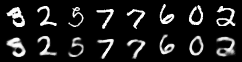

In [32]:

from IPython.display import Image
Image(filename='results/reconstruction_10.png') 



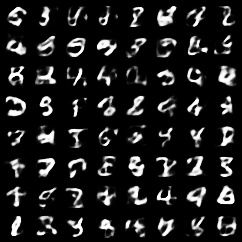

In [33]:
Image(filename='results/sample_10.png') 


In [0]:
import  matplotlib.pyplot as plt 
plt.plot(range(1, params.get("epochs") + 1),train_accuracy)
plt.plot(  range(1, params.get("epochs") + 1),train_loss)
plt.legend(["Train accuracy","Train loss"])
plt.show()